
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/Banner_IA2_1.png" style="width:1500px;heigth:100px">



# <center> 11. LSTM for Text generation </center>



## <span style="color:red"> Outline </span> 
1. **LSTM architectures: general overview**
2. **Text generation from LSTM**
3. **Teaching forcing from LSTM**




In [7]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/course-IA2')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/course-IA2


In [8]:
#@title Load libraries { display-mode: "form" }
#@markdown Here is important to change to GPU 

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
import nltk
nltk.download('punkt')

2.2.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#**1. LSTM architectures: general overview** 
*This part is based on [5]*

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies [Hochreiter & Schmidhuber (1997)](https://www.bioinf.jku.at/publications/older/2604.pdf). This model has been sucesuful on a large variety of problems, explicitly designed to avoid the long-term dependency problem.


Remember the simple structure of a standard RNN:

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width=700 heigth=100>
</center>
<center>The repeating module in a standard RNN contains a single layer.</center></center>

LSTMs also have this chain structure, but the repeating module has a different structure. Instead of having a single neural module (tanh), there are four:

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width=700 heigth=100>
</center>
<center>The repeating module in an LSTM contains four interacting layers.</center></center>

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png" width=700 heigth=100>
</center>


###**1.1 How  LSTM remember things?**

The answer is **a cell state**, represented as a top horizontal line. The cell state is kind of like a conveyor belt with some minor linear interactions. It’s very easy for information to just flow along it unchanged.

![texto del vínculo](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png)

The LSTM have the ability to remove or add information to the cell state througth **gates**. This gate structures are composed out of a sigmoid neural net layer and a pointwise multiplication operation.

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-gate.png" width=100 heigth=200>
</center>

The sigmoid layer weight how much of each component should be let through. A value of zero means “let nothing through,” while a value of one means “let everything through!”

**A LSTM has three of these gates to control the cell state.**

###**1.2  What information to forget?**

A  “forget gate layer” is a sigmoid tat decide which information to forget (remove). The outputs is a number between **0** (“completely null”) and **1** (“completely keep”) for each number in the cell state $C_{t−1}$. 

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png" width=700 heigth=200>
</center>

### **1.3. What information to store?**

The "information to store" has two parts (vectors): (1) a sigmoid layer called the “input gate layer” decides which values we’ll update (weights) and (2) a $\tanh$ layer that creates a vector of new candidate values, $\tilde{C}_t$, that could be added to the state. Then we going to combine these two vectors to create an updated state

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png" width=700 heigth=200>
</center>

### **1.4. How to update the cell state?**

To update the old cell state, $C_{t−1}$, we multiply the old state by $f_t$, forgetting the things we decided to forget earlier. Then we add $i_t∗\tilde{C}_{t}$. This is the new candidate values, scaled by how much we decided to update each state value.

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png" width=700 heigth=200>
</center>

### **1.5 What is the output?**

The output is based on cell state, but will be a filtered version. A sigmoid weight cell state, represented from a  tanh layer. 

<center>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png" width=700 heigth=200>
</center>

#**2. Text generation from LSTM**


In [12]:
#@title **code** To Build vocabulary, tokenize and prepare dataset
text = open("ai-2-uis-student/data/cien-as-fragment.txt").read().lower()
tokens = nltk.word_tokenize(text, preserve_line=False)
sentences = text.split('.')
sentences = [s+' .' for s in sentences]
tokenizer = Tokenizer(filters='#$%&*+-=@[\\]^_`{|}~\t\n', lower=False)
tokenizer.fit_on_texts(sentences)
print('Number of words in the vocabulary: ', len(tokenizer.word_index))
print(tokenizer.word_index)
print(tokenizer.index_word)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
coded_sentences = tokenizer.texts_to_sequences(sentences)

Number of words in the vocabulary:  2889
{'de': 1, '.': 2, 'la': 3, 'el': 4, 'y': 5, 'que': 6, 'en': 7, 'a': 8, 'un': 9, 'los': 10, 'con': 11, 'su': 12, 'se': 13, 'una': 14, 'por': 15, 'no': 16, 'del': 17, 'las': 18, 'sus': 19, 'josé': 20, 'arcadio': 21, 'le': 22, 'al': 23, 'para': 24, 'lo': 25, 'había': 26, 'buendía': 27, 'úrsula': 28, 'como': 29, 'más': 30, 'pero': 31, 'era': 32, 'hasta': 33, 'sin': 34, 'fue': 35, 'estaba': 36, 'entonces': 37, 'donde': 38, 'melquíades': 39, 'cuando': 40, 'toda': 41, 'casa': 42, 'tan': 43, 'desde': 44, 'él': 45, 'porque': 46, '»': 47, 'años': 48, 'dos': 49, 'tiempo': 50, 'mujer': 51, 'mientras': 52, 'niños': 53, 'aquella': 54, 'mundo': 55, 'aquel': 56, 'tenía': 57, 'vez': 58, 'dijo': 59, 'aldea': 60, 'vida': 61, 'es': 62, 'buendía,': 63, 'siempre': 64, 'varios': 65, 'ella': 66, 'esa': 67, 'volvió': 68, 'padre': 69, 'gitanos': 70, 'hizo': 71, 'les': 72, 'durante': 73, 'noche': 74, 'macondo': 75, 'todo': 76, 'hombres': 77, 'ya': 78, 'sólo': 79, 'gitano'

In [13]:
#@title **code:** Counting words and sentences
def counter_sentences_words(sentences):
  n_sentences = len(sentences)
  words_sentence = [len(s.split(' ')) for s in sentences]
  n_words = np.sum(words_sentence)
  n_words_max = np.max(words_sentence)
  
  return n_sentences, n_words, n_words_max
n_sentences, n_words, n_words_max = counter_sentences_words(sentences) 
print(n_sentences, n_words, n_words_max) 

365 9486 127


In [14]:
#@title **code** create n-grams
def create_ngrams_subsentences(coded_sentences):
  ngrams_subsentences = [] 
  for token_list in coded_sentences:
    for i in range(1, len(token_list)):
      n_gram_sequence = token_list[:i+1]
      ngrams_subsentences.append(n_gram_sequence)
  
  return ngrams_subsentences
ngrams_subsentences = create_ngrams_subsentences(coded_sentences)
ngrams_subsentences_padded = np.array(pad_sequences(ngrams_subsentences, maxlen=n_words_max, padding='pre'))

In [15]:
#@title **code** To build dataset

n_grams_history = ngrams_subsentences_padded[:,:-1]
next_words = ngrams_subsentences_padded[:,-1]
labels = tf.keras.utils.to_categorical(next_words, num_classes=len(tokenizer.word_index))

In [16]:
#@title **code** Create the model

def create_model(params):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Embedding(params.len_vocab, params.embedding_dim, input_length=params.max_sequence_len-1))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=params.rnn_units,
                                                          return_sequences=True,
                                                          activation=params.hidden_activation,
                                                          name='bilstm_layer1')))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=params.rnn_units,
                                                          return_sequences=False,
                                                          activation=params.hidden_activation,
                                                          name='bilstm_layer2')))
  model.add(tf.keras.layers.Dense(units=params.dense_units, 
                                   activation=params.dense_activation,
                                   name='dense1') )
  model.add(tf.keras.layers.Dense(units = params.len_vocab,
                                  activation='softmax',
                                  name='ouput_layer'))
  model.summary()
  return model

In [17]:
#@title **code** setup training step
def train(params, model, X, y):
    # Compile the model
    model.compile(loss=params.loss,
                  metrics=params.metrics,
                  optimizer=params.optimizer)  
    
    # fit
    history = model.fit(X,
                        y,
                        epochs=params.epochs,
                        verbose=params.verbose,
                        callbacks=params.callbacks)

    return model, history  

In [18]:
#@title **code** set params for training
Args = namedtuple('Args', 
                  ['len_vocab', 'embedding_dim', 'max_sequence_len', 'rnn_units', 'hidden_activation', 
                   'dense_units', 'dense_activation', 'loss' ,'metrics', 'optimizer', 'epochs', 'verbose', 'callbacks'])
params = Args(len_vocab=len(tokenizer.word_index), 
              embedding_dim=300,
              max_sequence_len=n_words_max,
              rnn_units=256,
              hidden_activation='tanh',
              dense_units=256,
              dense_activation='relu',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam',
              epochs=20,
              verbose=1,
              callbacks=[])

In [19]:
#@title **code** To crate the model

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_created = create_model(params)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 126, 300)          867000    
_________________________________________________________________
bidirectional (Bidirectional (None, 126, 512)          1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense1 (Dense)               (None, 256)               131328    
_________________________________________________________________
ouput_layer (Dense)          (None, 2890)              742730    
Total params: 4,456,706
Trainable params: 4,456,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_trained, history = train(params, model_created, n_grams_history, labels)

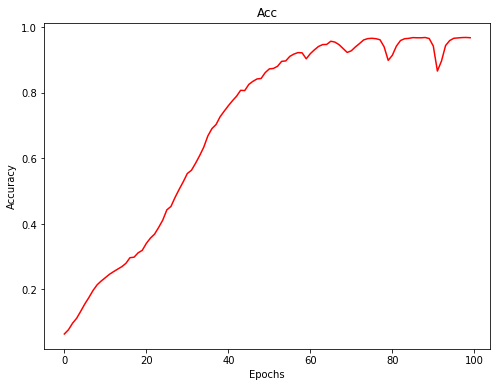

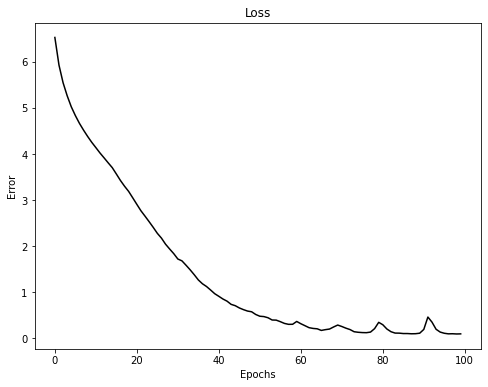

In [ ]:
#@title **code** plot results
#-----------------------------------------------------------
# Retrieve a list of list results on training data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

### **2.1 Text generation with n-gram approach**


<center>
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/teaching_forcing.png" width=700 heigth=200>
</center>

**Now, we are going to test this training scheme**

In [ ]:
#@title **code** to generate text
def generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=n_words_max-1, padding='pre')
    predicted = model_trained.predict_classes(token_list, verbose=0)[0]
    output_word = tokenizer.index_word[predicted]
    seed_text += " " + output_word
  return seed_text  

In [ ]:
#@title **code** Test!
seed_text = "Todos los años , por el mes de marzo ,"
next_words = 100
generated_text = generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max)
print(generated_text)

Todos los años , por el mes de marzo , nunca salieran del granero y que le dijera qué bárbaro, y que lo volviera a tocar y a decirle qué bárbaro . que se llevó los niños a rezar . manos del correo, y lo único que encontró de la nave fue el costillar carbonizado en medio de un campo de amapolas . para todo el mundo se volvió triste para siempre . otra de prudencio aguilar . a ambos transformaron todas sus propias especulaciones quiméricas . con sus loros pintados de todos los colores que recitaban romanzas italianas, y la gallina que ponía un centenar de huevos de oro


In [ ]:
#@title **code** Test!
seed_text = "El hielo,"
next_words = 100
generated_text = generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max)
print(generated_text)

El hielo, insistieron, que no tuvieran por donde entrar los piratas de sus mejillas flaccidas y sus labios marchitos, se estremecieron de pavor ante aquella prueba terminante de los poderes sobrenaturales del gitano . de medio recuerdos, y el emplasto para perder el tiempo, y un millar de invenciones más, tan ingeniosas e insólitas, que josé arcadio buendía hubiera querido inventar la máquina de la memoria para poder acordarse de todas . a travesar la región, que contaba con aquellos animales para ensanchar el desmedrado patrimonio doméstico, no consiguió disuadirlo . con la puerta del dormitorio y orientarse allí de tal modo


### **Save and use pre-trained models**

In [ ]:
model_trained.save('models/LSTM2_textGen_300_256_512_15.h5')

In [ ]:
new_model2 = tf.keras.models.load_model('models/...')
#@title **code** Test!
seed_text = "El hielo,"
next_words = 100
generated_text = generate_text(seed_text, next_words, new_model2, tokenizer, n_words_max)
print(generated_text)

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- compare with RNN model in previous Notebook
- Test with other configuration
- What about more epochs?
- Change the parameters and report the results
- There exist much other recurrent networks. Explore the GRU models
  - First implement change LSTM by GRU layers
  - Explain which is the difference with LSTM


## **References**

[1. Language Model ](https://www.cs.jhu.edu/~winston/mnlp/language-model/)

[2. N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf)

[3. Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

[4. A Comprehensive Survey of Deep Learning for Image Captioning](https://dl.acm.org/doi/abs/10.1145/3295748)

[5. Comprensive tutorial about LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/bannerThanks.jpg" style="width:1000px;">